In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score
import seaborn as sns
from sklearn.impute import SimpleImputer
import sys, os
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
# import tensorflow
# import torch
# import keras
#import theano
# import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# Function that combines different classification metrics to avoid repeated large blocks of code.
# Produces the confusion matrix, classification report (precision, recall, f1-score,..)
# ROC-AUC and ROC curve
# Precision-recall curve

def classifier_analysis(clf, X_test, y_test):
    y_predict = clf.predict(X_test)
    y_predict_proba= clf.predict_proba(X_test)[:,1]

    _ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)/len(y_test), ['True','False']).plot()

    crprt = classification_report(y_test, y_predict)
    print(crprt)

    logit_roc_auc = roc_auc_score(y_test, y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

    average_precision = average_precision_score(y_test, y_predict)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    return clf.score(X_test, y_test)

### Random Forest and Logistic Regression modeling of loan status.

In [4]:
loan_data = pd.read_csv('classification_loan_data.csv', index_col=False)

Need to take into consideration the time dependence element of this problem. Because we want to predict whether or not
to issue a loan, need to take into consideration the time series nature of the issuance date. The main consideration is during the cross-validation process later but reorder the data now as it will later be transformed by one-hot encoding. Specifically, it will be stored in a sparse matrix which is harder to manipulate.

In [5]:
# This step will be deprecated after newest data cleaning run. 
issued_datetime = pd.to_datetime(loan_data.issue_d)

loan_data = loan_data.loc[issued_datetime.sort_values().index,:]

Create a "hold-out" set of data that will used for final predictions and analysis after all cross-validation and
model learning has been accomplished. The loan issuance dates are aggregated by month, but from the metadata we know that the data is reported *quarterly*. Using this as motivation, the hold-out data will be the most recent quarter. Because the number of loans has grown over time, this one quarter represents nearly $1 / 7$ of all loan data of loans that have either been fully paid or charged off.

In [6]:
# Data goes from second quarter of 2007 to fourth quarter of 2015; the number of samples are skewed toawrds later dates;
# The data is reported quarterly; this should be represented in the cross validation/model selection process.
pind = pd.PeriodIndex(issued_datetime, freq='Q-DEC')


KBins needs numerical variables; use year.quarter (number.decimal). This transformation is not applied to the training data; it's just used

In [7]:
# Add the year to the decimal representing the quarter; Q1 = 0.0 , Q2 = 0.25, Q3 = 0.50, Q4 = 0.75
numerical_quarters = pind.year + (pind.quarter - 1)/4

In [8]:
kbd = KBinsDiscretizer(n_bins=6)
bin_masks = kbd.fit_transform(numerical_quarters.values.reshape(-1, 1)).toarray()

Size of the cross-validation folds

In [9]:
np.sum(bin_masks,axis=0)

array([ 93153.,  90943., 115805., 147183.,  64222., 162063.])

Scikit-learn wants iterable containing (train_indices, test_indices)

In [10]:
boolmasktoindex = lambda x : loan_data.index[np.array(x,dtype=bool)]
train_test_iterable = [(boolmasktoindex(np.sum(bin_masks[:,:i+1],axis=1)),boolmasktoindex(bin_masks[:,i+1])) for i in range(bin_masks.shape[1]-2)]
holdout_indices = [(boolmasktoindex(np.sum(bin_masks[:,:bin_masks.shape[1]-1],axis=1)),boolmasktoindex(bin_masks[:,bin_masks.shape[1]-1]))]

Have the cross validation folds, now need to create procedure which correctly preprocesses them before testing. Training component of folds are cumulative over time; always want to use as much information as possible.

There are too many values for the dates of the earliest credit known credit lines and zip codes; too many at least for one-hot encoding to be practical. Therefore, group zip_code by the first two digits as this retains the geographical information and group the earliest credit_line by using KBinsDiscretizer on the year; it needs a numerical value so the entire date cannot be used without modification. The reason for KBinsDiscretizer is that the distribution is not uniform over time, and it presents an unbiased selection/grouping method.

In [11]:
loan_data.loc[:,'zip_code'] = loan_data.zip_code.str.split('xx').str.join(sep='').apply(lambda x : x[:-1]).astype('category')
loan_data.loc[:, 'earliest_cr_line'] = pd.to_datetime(loan_data.earliest_cr_line).dt.year.astype('category')

In [12]:
y = loan_data.loan_status.astype(int)
X = loan_data.drop(columns=['loan_status'])

In [13]:
num_features = X.select_dtypes(exclude=['object','category']).columns
cat_features = X.select_dtypes(include=['object','category']).columns

In [14]:
X.select_dtypes(include=['object','category']).nunique()
# Does the number of categories influence the importance of the features?

term                           2
grade                          7
sub_grade                     35
emp_length                    12
home_ownership                 6
verification_status            3
issue_d                      103
purpose                       14
zip_code                     100
addr_state                    51
earliest_cr_line              67
initial_list_status            2
application_type               2
verification_status_joint      2
dtype: int64

In [15]:
# num_transformer = Pipeline(steps=[('scaler', StandardScaler()), ('encoder', KBinsDiscretizer())])
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')
col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                  ('cat', cat_transformer, cat_features)])

Special considerations need to be made because the problem is time dependent. The cross validation folds could normally be produced with TimeSeriesSplit(), but the distribution of the continuous numerical variables begs for rescaling. Therein lies the issue; however, as the renormalization using only train

1. Bin categorical data that has too many unique values.
2. Convert categorical data to discrete numerical data by means of OneHotEncoder.

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     76701
           1       0.37      0.02      0.05     14242

    accuracy                           0.84     90943
   macro avg       0.61      0.51      0.48     90943
weighted avg       0.77      0.84      0.78     90943



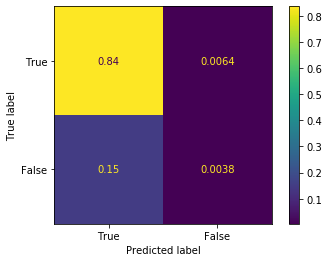

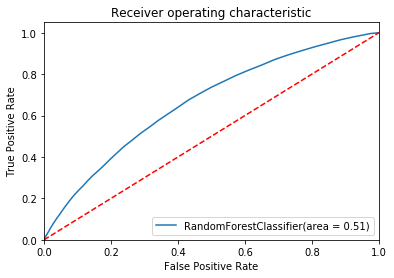

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.90      0.62      0.73     76701
           1       0.24      0.64      0.35     14242

    accuracy                           0.62     90943
   macro avg       0.57      0.63      0.54     90943
weighted avg       0.80      0.62      0.67     90943



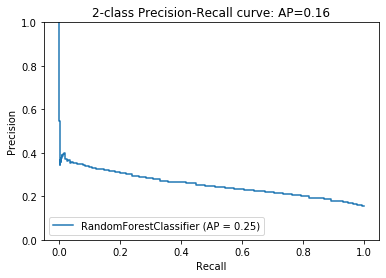

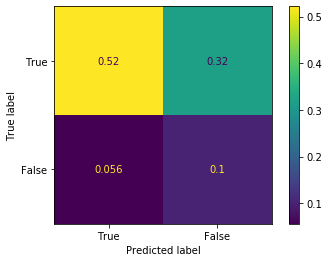

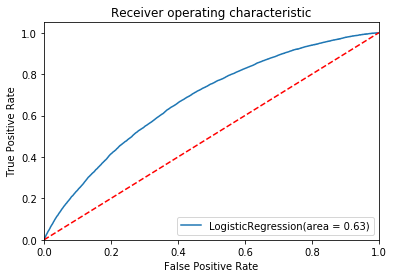

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     99510
           1       0.35      0.01      0.01     16295

    accuracy                           0.86    115805
   macro avg       0.61      0.50      0.47    115805
weighted avg       0.79      0.86      0.80    115805



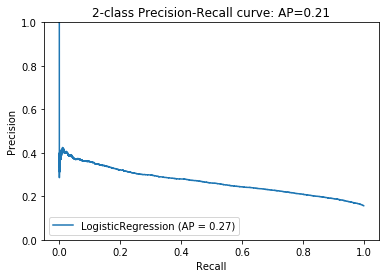

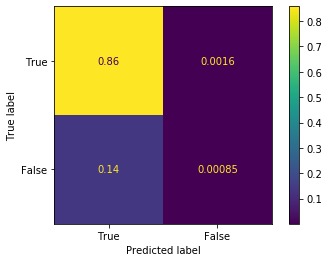

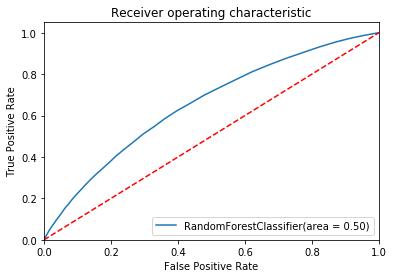

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.90      0.69      0.78     99510
           1       0.23      0.55      0.32     16295

    accuracy                           0.67    115805
   macro avg       0.57      0.62      0.55    115805
weighted avg       0.81      0.67      0.72    115805



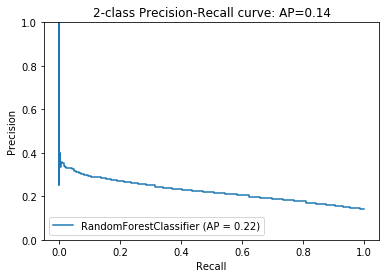

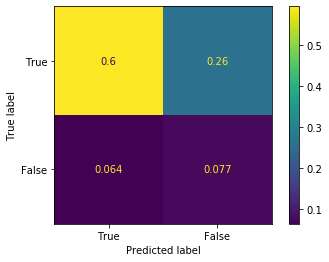

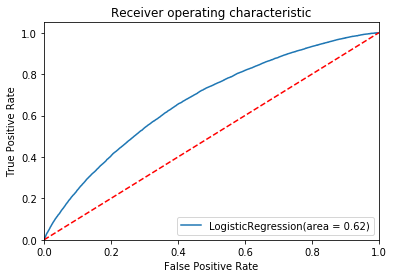

              precision    recall  f1-score   support

           0       0.86      1.00      0.92    125992
           1       0.45      0.00      0.00     21191

    accuracy                           0.86    147183
   macro avg       0.65      0.50      0.46    147183
weighted avg       0.80      0.86      0.79    147183



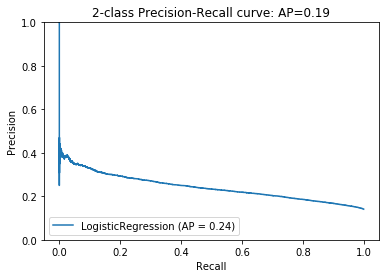

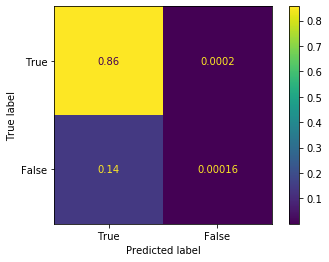

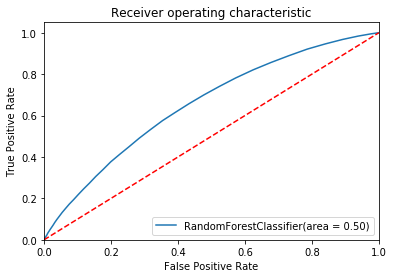

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.90      0.73      0.81    125992
           1       0.24      0.50      0.32     21191

    accuracy                           0.70    147183
   macro avg       0.57      0.62      0.56    147183
weighted avg       0.80      0.70      0.74    147183



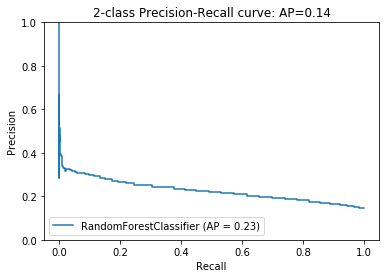

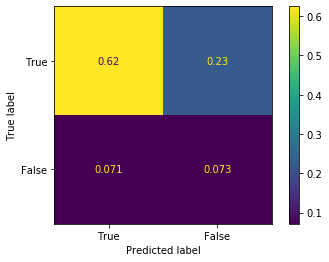

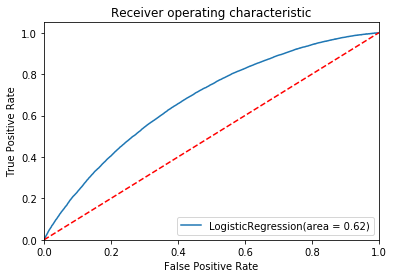

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     54344
           1       0.40      0.00      0.01      9878

    accuracy                           0.85     64222
   macro avg       0.62      0.50      0.46     64222
weighted avg       0.78      0.85      0.78     64222



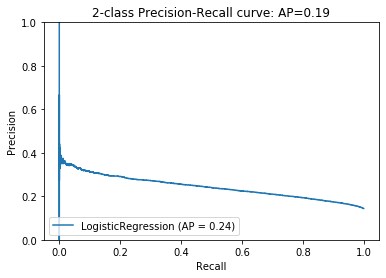

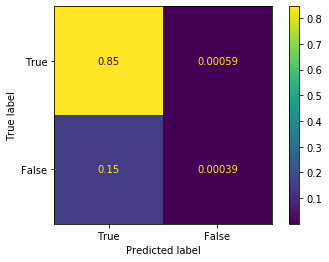

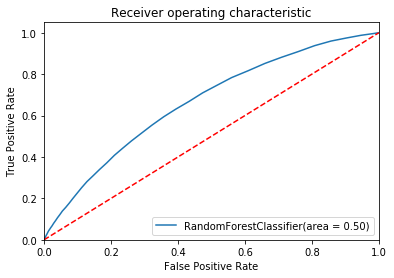

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.89      0.72      0.80     54344
           1       0.25      0.53      0.34      9878

    accuracy                           0.69     64222
   macro avg       0.57      0.62      0.57     64222
weighted avg       0.79      0.69      0.73     64222



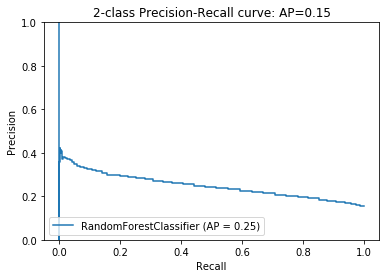

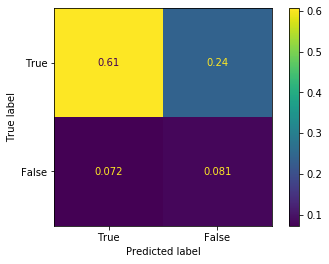

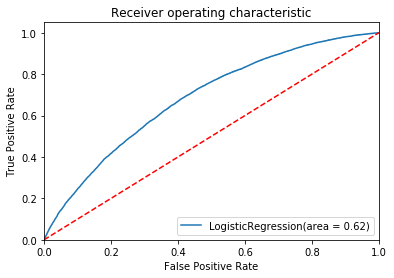

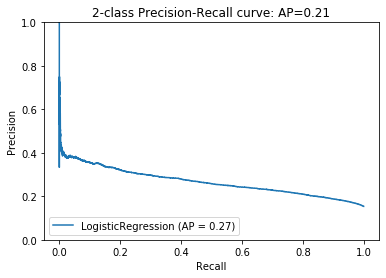

In [16]:
ranfor_models = []
logreg_models = []
ranfor_scores = []
logreg_scores = []

for train_indices, test_indices in train_test_iterable:
    X_train, y_train = X.loc[train_indices, :], y.loc[train_indices].values.ravel()
    X_test, y_test = X.loc[test_indices, :], y.loc[test_indices].values.ravel()
    # Create the unique categories to account for new/missing variables; creating "dummy categories" 'Missing' and 'Unknown/new'
    # has the same result as ignoring missing categories in the one-hot-encoding process; so can make the next step easier than
    #unique_categories = [np.array(set(X_train[col].sort_values().unique().tolist() + ['Missing', 'Unknown'])) for col in X_train.select_dtypes(include='object').columns]
    
    _ = col_transformer.fit(X_train)
    X_train_processed = col_transformer.transform(X_train)
    X_test_processed = col_transformer.transform(X_test)
    
    ranfor = RandomForestClassifier(class_weight='balanced', n_estimators=100)
    ranfor.fit(X_train_processed, y_train)
    ranfor_scr = classifier_analysis(ranfor, X_test_processed, y_test)
    
    logreg = LogisticRegression(class_weight='balanced', solver='saga', max_iter=300)
    logreg.fit(X_train_processed, y_train)
    logreg_scr = classifier_analysis(logreg, X_test_processed, y_test)
    
    ranfor_models += [ranfor]
    ranfor_scores += [ranfor_scr]
    
    logreg_models += [logreg]
    ranfor_scores += [logreg_scr]

Use all training/testing data to help scale the holdout data.

In [49]:
holdoutindicestrain, _ = train_test_iterable[1][0], train_test_iterable[1][1]

In [50]:
# holdoutindicestrain =  holdout_indices[0][0]
holdoutindicestest = holdout_indices[0][1]

In [57]:
y_test_holdout.shape

(162063,)

In [53]:
X_train_holdout = X.loc[holdoutindicestrain, :]#, y.loc[holdoutindicestrain].values.ravel()
X_test_holdout, y_test_holdout = X.loc[holdoutindicestest, :], y.loc[holdoutindicestest].values.ravel()

In [60]:
X_train_holdout.shape, X_test_holdout.shape, y_test_holdout.shape

((184096, 20), (162063, 20), (162063,))

In [61]:
_ = col_transformer.fit(X_train_holdout)
# Just need to fit the column transformer; aren't really training. 
# X_train_holdout_processed = col_transformer.transform(X_train_holdout)
X_test_holdout_processed = col_transformer.transform(X_test_holdout)

In [35]:
best_model_ = ranfor_models[1][0]

Can't actually use the entire training and testing data to scale/encode because it results in more features than the model has.

              precision    recall  f1-score   support

           0       0.85      1.00      0.92    138284
           1       0.50      0.00      0.00     23779

    accuracy                           0.85    162063
   macro avg       0.68      0.50      0.46    162063
weighted avg       0.80      0.85      0.79    162063



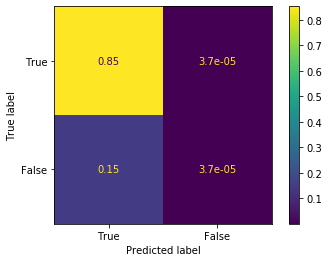

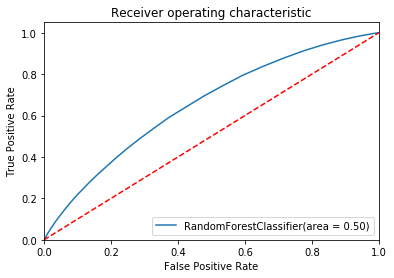

0.8532731098400005

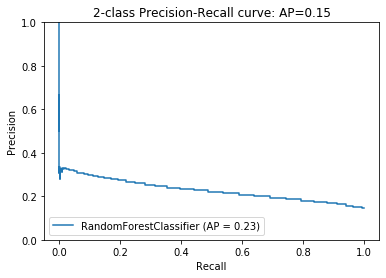

In [62]:
classifier_analysis(best_model_, X_test_holdout_processed, y_test_holdout)

The one hot encoding can throw an error if there are categories in the test set not in the train set; as the categories are
quantities known before hand it should be ok to pass to the encoder; or does this contaminate the test data? The issue is that the lack of a category in the training data prevents accurate prediction as by definition there is no training done on those values.

Is it ok to "look at" the test data? The issue arises when there are categories that are in the testing set that are not
in the training set. If the time-series cross validation folds are not cumulative then this becomes even more of a problem.
If kept as a general procedure, that is, relabel any categories unique to the testing set as "Unknown", then perhaps it can work. I.e. relabel values in the testing set that are "unknown" to the training set; this dummy variable is a flag to the algorithm that these values are "special". From Mike; if we know the categories before hand, use that set of unique values and then add two dummy columns: "Missing" and "Unknown/New"

In [17]:
# ranfor_param_grid={'n_estimators':[5,10,15]}
# logreg_param_grid = {'tol':[1e-1, 1e-2, 1e-4]}

# ranfor_cv = RandomForestClassifier(class_weight='balanced')
# ranfor_model_ = GridSearchCV(ranfor_cv, ranfor_param_grid, cv=TimeSeriesSplit(n_splits=3))
# ranfor_model_.fit(X_train, y_train)